In [1]:
basedir = '/home/abhinavgupta0110/generalized_nCM'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'generalized_nCMs'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDistDDE_train_HOTs as ncm
import src.burgers_eqn_case_findiff.burgers_eqn as burg
from src.burgers_eqn_case_findiff.burgers_eqn_helper_classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy as spy
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from shutil import move
import pickle

print(tf.__version__)

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.5.0


## Define some useful classes

### Class for user-defined arguments

In [4]:
class burg_ncm_args(ncm.ncm_arguments, burg.burg_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, 
                 decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 tau_max = 1.1, tau = 0.2,
                 model_dir = 'ROM_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2., nt = 200, 
                 train_ens_size = 1, x_left = [0.], x_right = [1.], nx_train_hf = [100], nx_train_lf = [25], Re = [250], 
                 dleft_bv_dt = [0.], dright_bv_dt = [0.], dbc_l = [1], nbc_l = [0], dbc_r = [1], nbc_r = [0],
                 isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1, ens_to_plot = -1, read_hf_data = 0, read_hf_data_fac = 4, 
                 use_analytical_sol = 0, lambda_l1_mark = 0., lambda_l2_mark = 0., 
                 lambda_l1_non_mark = 0., lambda_l2_non_mark = 0., prune_thres = 0., mse_weight = 0., max_deriv = 2,
                 acc = 2, acc_advec = 1, norm_Re = 1000, norm_nx = 50): # add more arguments as needed
        
        ncm.ncm_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, 
                           tau_max = tau_max, tau = tau, model_dir = model_dir, restart = restart, val_percentage = val_percentage, 
                           isplot = isplot, is_tstart_zero = is_tstart_zero)
        
        self.args_train_hf = []
        for i in range(train_ens_size):
            self.args_train_hf.append(burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_hf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv, 
                                         acc = acc, acc_advec = acc_advec))
            
        self.args_train_lf = []
        for i in range(train_ens_size):
            self.args_train_lf.append(burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_lf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec))
        
        self.train_ens_size = train_ens_size
        i = ens_to_plot
        self.args_eval_hf = burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_hf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec)
        self.args_eval_lf = burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_lf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec)
        
        self.args_norm = burg.burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = norm_nx, Re = norm_Re, 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec)
        
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps
        self.read_hf_data = read_hf_data
        self.read_hf_data_fac = read_hf_data_fac
        self.use_analytical_sol = use_analytical_sol
        
        self.lambda_l1_mark = lambda_l1_mark
        self.lambda_l2_mark = lambda_l2_mark
        self.lambda_l1_non_mark = lambda_l1_non_mark
        self.lambda_l2_non_mark = lambda_l2_non_mark
        self.prune_thres = prune_thres
        self.mse_weight = mse_weight

### Define the neural net architecture

In [5]:
class NNFunc_mark(tf.keras.Model):

    def __init__(self, **kwargs):
        super(NNFunc_mark, self).__init__(**kwargs)
        
        self.out = tf.keras.layers.Dense(1, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=False)
        
    
    def norm_init(self, norm_const, dx, nu):
        self.norm_const = norm_const
        self.nu = tf.stack([nu, nu, nu], axis=-1)
        self.dx_lin = tf.stack([dx**(-2), dx**(-1), dx**0], axis=-1)
        self.dx_itself = tf.stack([dx**(-1), dx**1, dx**3], axis=-1)
        self.dx_mult = tf.stack([dx**0, dx**2, dx**1], axis=-1)
        
    def process_input(self, y, shp):     
               
        y = tf.reshape(y, shp)
        
        return y
    
    @tf.function
    def pass_layers(self, z):
        
        for i in range(len(self.layers)):
            z = self.layers[i](z)
            
        return z
    
    def call(self, z):
        
        z_shp = tf.shape(z)
        
        z = self.process_input(z, [-1, z_shp[-1]])
        
        z = tf.cast(z, tf.float64)
        
        dx_lin = tf.tile(self.dx_lin, tf.constant([z.shape[0], 1]))
        dx_itself = tf.tile(self.dx_itself, tf.constant([z.shape[0], 1]))
        dx_mult = tf.tile(self.dx_mult, tf.constant([z.shape[0], 1]))
        nu = tf.tile(self.nu, tf.constant([z.shape[0], 1]))
        
        z_lin = tf.einsum('ab, ab -> ab', z, dx_lin)
        z_lin = tf.einsum('ab, ab -> ab', z_lin, nu)
        
        z_itself = tf.einsum('ab, ab -> ab', z, z)
        z_itself = tf.einsum('ab, ab -> ab', z_itself, dx_itself)
        
        z_mult = tf.einsum('ab, ab -> ab', z, tf.roll(z, shift = -1, axis = -1))
        z_mult = tf.einsum('ab, ab -> ab', z_mult, dx_mult)
        
        z = tf.cast(tf.concat([z_itself[:, 1:], z_mult[:, 1:]], axis=-1), tf.float32)
        
        z = self.pass_layers(tf.cast(z, tf.float32))
        
        z = self.process_input(z, z_shp[0:-1])
        
        return z

In [6]:
class split_zy:
    def __init__(self, zy, args):
        self.zy = zy
        self.args = args

    def get_z(self, t):
        return self.zy(t)[:, :self.args.state_dim]
    
    def get_y(self, t):
        return self.zy(t)[:, self.args.state_dim:]

In [7]:
class ODEFunc(tf.keras.Model):

    def __init__(self, mark_nn_part, rom_model, app, norm_const, **kwargs):
        super(ODEFunc, self).__init__(**kwargs)
        self.mark_nn_part = mark_nn_part
        
        dx = rom_model.grid.x_grid[1] - rom_model.grid.x_grid[0] 
        dx = tf.convert_to_tensor([dx])
        nu = app.nu
        nu = tf.convert_to_tensor([nu], tf.float64)
        self.mark_nn_part.norm_init(norm_const, dx, nu)
        
        self.rom_model = rom_model
        self.args = app
        
    def overwrite_rom(self, app, rom_model, norm_const):
        self.rom_model = rom_model
        dx = rom_model.grid.x_grid[1] - rom_model.grid.x_grid[0]
        dx = tf.convert_to_tensor([dx])
        nu = app.nu
        nu = tf.convert_to_tensor([nu], tf.float64)
        self.args = app
        self.mark_nn_part.norm_init(norm_const, dx, nu)
        
    def process_input(self, zy, t ,tau, flag_fwd=0):     
        
        input = [self.compute_derivatives(zy(t)[:, :self.args.state_dim], flag_fwd)]
        
        return input
    
    def call_nn_part_indiv(self, z, flag_mark = 0, flag_fwd = 0):
        
        z = self.compute_derivatives(z, flag_fwd)
        
        return self.mark_nn_part(z)
    
    def compute_derivatives(self, u, flag_fwd = 0):
        if flag_fwd:
            u_x = np.einsum('ab, cb -> ca', self.rom_model.full_vander_dx_upwind, u.numpy())
        else:
            u_x = np.einsum('ab, cb -> ca', self.rom_model.full_vander_dx, u.numpy())
        
        u_stack = [u, u_x]
        
        for i in range(2, self.args.max_deriv+1):
            u_stack.append(np.einsum('ab, cb -> ca', self.rom_model.full_vander[i], u.numpy()))
        
        u_stack = tf.convert_to_tensor(np.stack(u_stack, axis=-1))
        
        return u_stack

    def __call__(self, uy, t ,tau, t_start = np.array([0.])):    
        
        input = self.process_input(uy, t ,tau, flag_fwd=1)
        
        u_t = input[0][:, :, 0]
        u_t_int = u_t[:, self.args.max_deriv - 1:-(self.args.max_deriv - 1)]
        
        du_dt_int = self.rom_model.rhs_int(t, u_t.numpy(), u_t_int.numpy())
        
        du_dt_int = du_dt_int + self.call_nn_part_indiv(u_t, flag_mark = 1, flag_fwd=1)[:, self.args.max_deriv - 1:-(self.args.max_deriv - 1)].numpy()
        
        du_dt_bnd = self.rom_model.boundary(t, u_t.numpy(), du_dt_int)
        
        du_dt = np.concatenate((du_dt_bnd[:, 0:self.args.max_deriv - 1], du_dt_int, du_dt_bnd[:, self.args.max_deriv - 1:]), axis=-1)
        
        du_dt = tf.convert_to_tensor(du_dt, dtype=tf.float32)
        
        return du_dt

### Initialize model related parameters

In [8]:
args = burg_ncm_args(batch_time = 6*5, batch_time_skip = 1, batch_size = 2, epochs = 30, learning_rate = 0.025, 
                 decay_rate = 0.95, test_freq = 1, plot_freq = 1, tau_max = 0.5, tau = 0.075,
                 model_dir = 'burgers_testcase_nODE_v2/model_dir_case1', restart = 0, val_percentage = 0.5,
                 T = 4.0, nt = 400, train_ens_size = 1, x_left = [0.], x_right = [1.25], 
                 nx_train_hf = [250], nx_train_lf = [50], Re = [1000], 
                 dleft_bv_dt = [0.], dright_bv_dt = [0.], dbc_l = [1], nbc_l = [0], dbc_r = [0], 
                 nbc_r = [1], isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'vode', nsteps = 100, ens_to_plot = -1, read_hf_data = 0, read_hf_data_fac = 4, 
                 use_analytical_sol = 1, lambda_l1_mark = 5e-4, lambda_l2_mark = 5e-4, lambda_l2_non_mark = 5e-4,
                 prune_thres = 5e-3, mse_weight = 0., max_deriv = 2,
                 acc = 4, acc_advec = 1) 

In [9]:
testcase_dir = 'generalized_nCMs/testcases/burgers_eqn_findiff'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir)

### Run Setup

In [10]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup

High resolution model done!
Low resolution model done!


## Main part starts here

### Make objects and define learning-rate schedule

In [11]:
# create ROM RHS for evaluation
grid_obj = fdgen.grid(args.args_eval_lf)
deriv_obj = fdgen.deriv(args.args_eval_lf, grid_obj)

eval_burg_obj = burg.burg_rhs(args = args.args_eval_lf, deriv_obj = deriv_obj, grid_obj = grid_obj)

# create ROM RHS for all the training ensemble members
plot_obj = custom_plot(tf.concat([true_u_low_res, val_true_u_low_res], axis=0), 
                       tf.concat([u_low_res, val_u_low_res], axis=0), 
                       tf.convert_to_tensor(fdgen.grid(args.args_eval_lf).x_grid_real), 
                       tf.concat([t, val_t], axis=0), save_dir_obj.figsave_dir, args.args_eval_lf, args.restart)
    
    
func = ODEFunc(NNFunc_mark(), eval_burg_obj, args.args_eval_lf, norm_eval)

### Plot training time

In [12]:
func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))

In [13]:
pred_zy = ddeinttf(func, true_u0, tf.concat([t, val_t], axis=0), fargs=(args.tau,), alg_name = args.ode_alg_name, nsteps = args.nsteps)

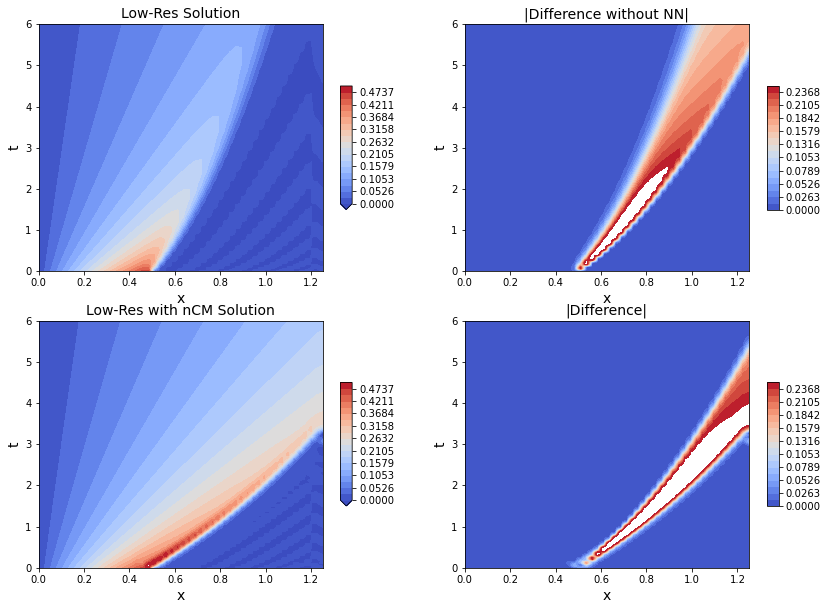

In [14]:
plot_obj.plot(pred_zy[:, :, :args.args_eval_lf.state_dim], epoch = 0)

In [15]:
func.mark_nn_part.summary()

Model: "nn_func_mark"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [16]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*self.thres
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)

        error = np.mean(np.array(error))
        return error

In [17]:
truth = tf.concat([true_u_low_res, val_true_u_low_res], axis=0)

err_obj = compute_error(truth)

In [18]:
err_obj.l2_error(pred_zy[:, :, :args.args_eval_lf.state_dim])

array([0.48645493], dtype=float32)